In [1]:
import pandas as pd
import numpy as np

In [2]:
np.random.seed(7777)

In [3]:
ids = pd.read_csv("ids.csv")
ids

,id
0,524354
1,61537
2,1142564
3,300432
4,83777
...,...
95,912470
96,1526265
97,52803
98,373737


In [4]:
edges = pd.read_csv("edges.csv")
edges

,id_1,id_2,value,n_transactions
0,878327,1133997,478035.238733,277.747437
1,707356,1341541,442189.669684,80.997950
2,169982,494074,353097.929209,287.789650
3,551010,979933,537749.674840,426.743337
4,76064,597023,418990.198382,287.789650
...,...,...,...,...
4685639,533291,1134794,275822.479741,1.000000
4685640,929970,1378868,507684.088750,1.000000
4685641,45803,829031,318785.728608,1.000000
4685642,1266550,1448478,494106.825312,1.000000


In [5]:
vertices = pd.read_csv("vertices.csv")
vertices

,id,main_okved,region_code,company_type
0,1,46.75,77,Limited
1,2,41.20,78,Limited
2,3,25.11,50,Limited
3,4,45.31,89,Limited
4,5,56.10,50,Limited
...,...,...,...,...
1534744,1534745,63.99,77,Individual
1534745,1534746,47.19,66,Individual
1534746,1534747,41.20,77,Individual
1534747,1534748,74.20,33,Individual


In [6]:
edges[edges.id_1.isin(ids.id) | edges.id_2.isin(ids.id)][["id_1", "id_2"]]

,id_1,id_2
108,524354,958357
194,80484,319548
309,776150,786322
312,524354,1096103
342,776150,1300786
...,...,...
4685417,263624,567406
4685449,41216,328439
4685479,41216,635885
4685507,410574,1523148


In [7]:
(edges["id_1"] > edges["id_2"]).any()

False

In [8]:
vertices.index

RangeIndex(start=0, stop=1534749, step=1)

In [9]:
from matplotlib import pyplot as plt

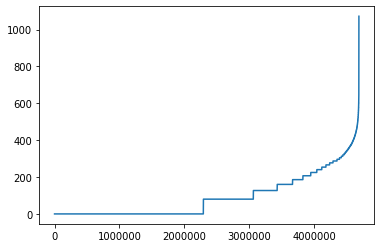

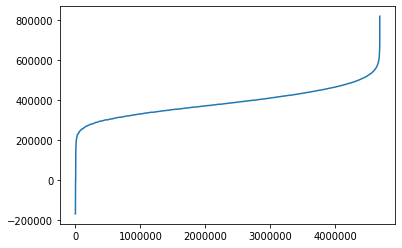

([<matplotlib.lines.Line2D at 0x7efbd1a0cc50>], None)

In [10]:
def gendist(df, col):
    return df[col].sort_values().reset_index()[col]
plt.plot(gendist(edges, "n_transactions")), plt.show()
plt.plot(gendist(edges, "value")), plt.show()

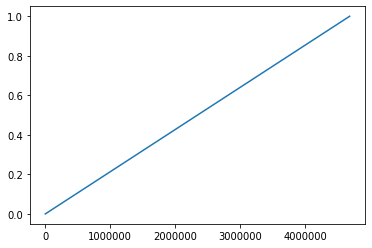

In [11]:
def normalize(df, col, by="value"):
    dist = df.sort_values(by=[col, by])[col].reset_index()
    return (dist["index"].rename(col) + 1) / len(df)
plt.plot(normalize(edges, "n_transactions").sort_values().reset_index()["n_transactions"])

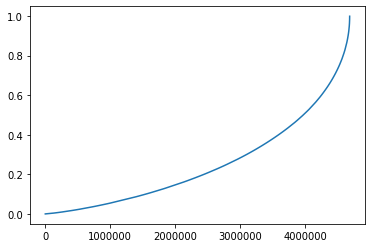

In [12]:
plt.plot((normalize(edges, "value") * normalize(edges, "n_transactions")).sort_values().reset_index()[0])

In [13]:
edges_base = 0.1
edges_weight = 0
iters = 10

def train_data(iters=iters):
    xs = []
    ys = []
    ws = []
    xs.append(edges[["id_1", "id_2"]])
    ys.append(pd.Series(np.ones(len(edges), dtype="int"), name="y"))
    ws.append(normalize(edges, "value") * normalize(edges, "n_transactions") * edges_weight + edges_base)
    for i in range(iters):
        first = pd.Series(np.random.randint(1, len(vertices) + 1, size=len(vertices))).rename("id_1")
        other = pd.Series(np.random.randint(1, len(vertices) + 1, size=len(vertices))).rename("id_2")
        train_edges = pd.concat([vertices.id.rename("id_1"), other], axis=1)
        xs.append(train_edges)
        ys.append(pd.Series(np.zeros(len(vertices), dtype="int"), name="y"))
        ws.append(pd.Series(np.ones(len(vertices)), name="w"))
    concat = lambda its: pd.concat(its).reset_index().drop(columns="index")
    return concat(xs), concat(ys), concat(ws)
xd, y, w = train_data()
xd, y, w

(             id_1     id_2
 0          878327  1133997
 1          707356  1341541
 2          169982   494074
 3          551010   979933
 4           76064   597023
 ...           ...      ...
 20033129  1534745    29816
 20033130  1534746   929410
 20033131  1534747  1020125
 20033132  1534748   866882
 20033133  1534749   497129
 
 [20033134 rows x 2 columns],           y
 0         1
 1         1
 2         1
 3         1
 4         1
 ...      ..
 20033129  0
 20033130  0
 20033131  0
 20033132  0
 20033133  0
 
 [20033134 rows x 1 columns],             0
 0         0.1
 1         0.1
 2         0.1
 3         0.1
 4         0.1
 ...       ...
 20033129  1.0
 20033130  1.0
 20033131  1.0
 20033132  1.0
 20033133  1.0
 
 [20033134 rows x 1 columns])

In [14]:
def preprocess(edges):
    verts = vertices.copy()
    verts["main_okved"] = verts["main_okved"].astype("str")
    x = edges.merge(verts, left_on="id_1", right_on="id")
    x = x.merge(verts, left_on="id_2", right_on="id", suffixes=("_1", "_2")).drop(["id_1", "id_2"], axis=1)
    return x
x = preprocess(xd)
x

,main_okved_1,region_code_1,company_type_1,main_okved_2,region_code_2,company_type_2
0,68.2,23,Individual,47.59,23,Individual
1,43.29,2,Limited,47.59,23,Individual
2,49.41,66,Limited,47.59,23,Individual
3,46.9,23,Limited,47.59,23,Individual
4,46.43,23,Limited,47.59,23,Individual
...,...,...,...,...,...,...
20033129,41.2,66,Individual,85.41,54,NonComm
20033130,47.11,77,Limited,71.2,50,Limited
20033131,31.0,77,Limited,41.2,54,Individual
20033132,46.69,66,Limited,81.22,78,Limited


In [15]:
#from sklearn.model_selection import train_test_split

In [16]:
#x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=7777, test_size=0.5)

In [17]:
#w_train = w.reindex(index=x_train.index)
#w_train

In [18]:
#w_val = w.reindex(index=x_train.index)
#w_val

In [19]:
import catboost as cb

In [28]:
parameters = {
    "iterations": 500,
    "task_type": "GPU",
    # "gpu_ram_part": 0.8,
    "eval_metric": "Accuracy",
    # "use_best_model": True,
    "random_seed": 7777,
    # "od_type": "IncToDec"
}
cat_features = [0, 1, 2, 3, 4, 5]
model = cb.CatBoostClassifier(**parameters)
#pool_train = cb.Pool(x_train, y_train, cat_features=cat_features)
#pool_val = cb.Pool(x_val, y_val, cat_features=cat_features)
model.fit(x, y, cat_features)

Learning rate set to 0.5
0:	learn: 0.7849908	total: 3.68s	remaining: 30m 38s
1:	learn: 0.7938255	total: 7.59s	remaining: 31m 29s
2:	learn: 0.7962296	total: 10.2s	remaining: 28m 17s
3:	learn: 0.7993780	total: 14.3s	remaining: 29m 27s
4:	learn: 0.8012339	total: 17.7s	remaining: 29m 10s
5:	learn: 0.8019264	total: 21.1s	remaining: 28m 57s
6:	learn: 0.8027120	total: 24.9s	remaining: 29m 13s
7:	learn: 0.8031143	total: 28.8s	remaining: 29m 29s
8:	learn: 0.8035741	total: 32.4s	remaining: 29m 28s
9:	learn: 0.8042853	total: 36.2s	remaining: 29m 35s
10:	learn: 0.8046605	total: 39.7s	remaining: 29m 23s
11:	learn: 0.8049456	total: 43.1s	remaining: 29m 11s
12:	learn: 0.8051389	total: 46.5s	remaining: 29m 2s
13:	learn: 0.8052372	total: 49.4s	remaining: 28m 33s
14:	learn: 0.8053633	total: 53s	remaining: 28m 33s
15:	learn: 0.8053860	total: 56.3s	remaining: 28m 21s
16:	learn: 0.8055009	total: 59.8s	remaining: 28m 20s
17:	learn: 0.8056301	total: 1m 3s	remaining: 28m 22s
18:	learn: 0.8057365	total: 1m 6s	

In [29]:
counts = edges.id_1.append(edges.id_2).reset_index(drop=True).value_counts()
counts = pd.DataFrame(counts.rename("id"))
merges = counts.merge(ids, left_index=True, right_on="id", how="left", indicator=True)
merges.index = merges.id
counts = counts[merges._merge == "both"]
counts /= counts.sum()
counts = np.ceil(counts * 300000).astype("int")
counts

,id
524354,10589
61537,8005
1142564,6879
300432,6091
58408,5799
...,...
1392199,1818
912470,1818
1526265,1814
1523148,1807


In [30]:
from tqdm import tqdm

def test_data(i):
    xs = []
    id_1 = pd.Series(np.full(len(vertices), i), name="id_1")
    id_2 = vertices.id.rename("id_2")
    x = pd.concat([id_1, id_2], axis=1)
    xs.append(x)
    x = pd.concat(xs)
    x.values.sort()
    x.drop_duplicates(inplace=True)
    merge = x.merge(edges, on=["id_1", "id_2"], how="left", indicator=True)
    x = x[merge._merge == "left_only"].reset_index().drop(columns="index")
    return x

def test_predict():
    predictions = pd.DataFrame(columns=["id_1", "id_2", "proba"])
    for i, (v,) in tqdm(counts.iterrows()):
        xd_test = test_data(i)
        x_test = preprocess(xd_test)
        yd_test = model.predict_proba(x_test)[:, 1]
        y_test = pd.concat([xd_test, pd.Series(yd_test, name="proba")], axis=1)
        y_test.sort_values("proba", ascending=False, inplace=True)
        y_test = y_test.iloc[:v]
        predictions = pd.concat([predictions, y_test])
    predictions.sort_values("proba", ascending=False, inplace=True)
    predictions = predictions.drop_duplicates().iloc[:100000]
    return predictions

y_test = test_predict()
y_test

100it [09:33,  5.74s/it]


,id_1,id_2,proba
946338,331678,946771,0.999995
1360970,331678,1361608,0.999995
775320,331678,775674,0.999995
1491229,331678,1491922,0.999994
1425534,331678,1426202,0.999994
...,...,...,...
795140,386565,795436,0.993960
809404,386565,809706,0.993960
1235190,811809,1235625,0.993960
906343,811809,906655,0.993960


In [31]:
result = y_test.reset_index()[["id_1", "id_2"]]
result

,id_1,id_2
0,331678,946771
1,331678,1361608
2,331678,775674
3,331678,1491922
4,331678,1426202
...,...,...
99995,386565,795436
99996,386565,809706
99997,811809,1235625
99998,811809,906655


In [32]:
result.to_csv('submission.csv', index=False)